In [3]:
%load_ext autoreload
%matplotlib inline

In [4]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle 

from scipy.ndimage.filters import gaussian_filter,convolve
# interactive
from mpl_toolkits.axes_grid1 import make_axes_locatable
# animation
from matplotlib import animation


In [5]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [6]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')
resultdir = os.path.join(repodir,'results')

## Load own libraries
from moistdryedge import *
from conditionalstats import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

# Load data

In [56]:
# simname = 'SAM6113_RCE_SST301d1p0r1'
# simname = 'SAM6113_RCE_SST303d1p0r1'
# simname = 'SAM6113_RCE_SST305d1p0r1'
# simname = 'SAM6113_RCE_SST305d2p0r1'
simname = 'SAM6113_RCE_SST307d1p0r1'
# simname = 'SAM6113_RCE_SST309d1p0r1'
print('simname:',simname)

def getDtype(simname):
    return int(simname[-5:-4])

##-- number of processors
if getDtype(simname) == 1:
    nproc = 256
elif getDtype(simname) == 2:
    nproc = 128
print('nprocs: %d'%nproc)

##-- timestamp
ndays = 50
# ndays = 33
dt = 10 # seconds
nsteps = int(ndays*86400/dt) # number of timesteps
tstamp = '{:0>10d}'.format(nsteps)
print('timestamp: %s'%tstamp)

# create output subdirectories
os.makedirs(os.path.join(figdir,simname),exist_ok=True)
os.makedirs(os.path.join(resultdir,simname),exist_ok=True)

# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile2D = "%s_%d.2Dcom_1.nc"%(caseid,nproc)
inputfile3D = "%s_%d_%s.com3D.alltimes.nc"%(caseid,nproc,tstamp)

simname: SAM6113_RCE_SST307d1p0r1
nprocs: 256
timestamp: 0000432000
caseid: RCE_SST307d1p0r1


In [57]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))

load 2D data


In [58]:
print('load 3D data')
data3D = xr.open_dataset(os.path.join(simdir,inputfile3D))

load 3D data


In [59]:
print("save z coordinate")
file_z_coord = os.path.join(resultdir,simname,"z_coord.p")
pickle.dump(data3D.z,open(file_z_coord,"wb"))

save z coordinate


# Calculate stats over time

In [60]:
vars4stats = ['PW','CRH','LHF','SHF','LWNT','LWNS']

## Edge 

### Load edges if existing

In [61]:

file_edge_PW = os.path.join(resultdir,simname,"edge_PW.p")
file_edge_CRH = os.path.join(resultdir,simname,"edge_CRH.p")

if os.path.exists(file_edge_PW):
    edge_PW = pickle.load(open(file_edge_PW,"rb"))
if os.path.exists(file_edge_CRH):
    edge_CRH = pickle.load(open(file_edge_CRH,"rb"))


AttributeError: 'Variable' object has no attribute '__dict__'

### Calculate edges

In [62]:
print("Initialize and get edge")

#- Get edge
# PW
edge_PW = EdgeOverTime()
edge_PW.compute(data2D.PW)
# CRH
edge_CRH = EdgeOverTime()
edge_CRH.compute(data2D.CRH)

Initialize and get edge


In [63]:
print('Calculate edge and stats for boundary defined based on CRH and PW')

#- Calculate stats
for varid in vars4stats:
    print(varid,end=', ')
    for edge in edge_PW,edge_CRH:
        
        # mean on edge
        edge.computeStatOnEdge(data2D[varid],varid)
        # std on edge
        edge.computeStatOnEdge(data2D[varid],varid,fname='std')
        # mean of gradient norm on edge
        edge.computeGradNormStatOnEdge(data2D[varid],varid)
        # std of gradient norm on edge
        edge.computeGradNormStatOnEdge(data2D[varid],varid,fname='std')

print()

Calculate edge and stats for boundary defined based on CRH and PW
PW, CRH, LHF, SHF, LWNT, LWNS, 


In [64]:
print('Calculate 3D stats on edge for boundary defined based on CRH and PW')

vars3D_stats_on_edge = 'QV',

#- Calculate stats
for varid in vars3D_stats_on_edge:
    print(varid,end=', ')
    for edge in edge_PW,edge_CRH:
        
        # mean on edge
        edge.computeStatOnEdge(data3D[varid],varid)
        # std on edge
        edge.computeStatOnEdge(data3D[varid],varid,fname='std')
        # mean of gradient norm on edge
        edge.computeGradNormStatOnEdge(data3D[varid],varid)
        # std of gradient norm on edge
        edge.computeGradNormStatOnEdge(data3D[varid],varid,fname='std')

print()

Calculate 3D stats on edge for boundary defined based on CRH and PW
QV, 


In [65]:
def showErrorRange(ax,x,y,dy,**kwargs):
    
    ax.fill_between(x,y-dy,y+dy,**kwargs)

In [66]:
print("plot to compare edges defined from CRH and PW: stats on the boundary")

x = data2D.time

for varid in vars4stats:

    # create figure 
    fig,ax0 = plt.subplots(ncols=1,figsize=(6,5))
    
    for refvarid in 'PW','CRH':

        edge = getattr(thismodule,"edge_%s"%refvarid)
        # Get data
        v_mean = getattr(edge,"%s_mean"%varid)
        v_std = getattr(edge,"%s_std"%varid)
        # plot
        showErrorRange(ax0,x,v_mean,v_std,alpha=0.2)
        ax0.plot(x,v_mean,label='%s-edge'%refvarid)

    # labels
    ax0.set_xlabel('Days')
    ax0.set_ylabel('%s (%s)'%(varid,data2D[varid].units))
    ax0.legend()

    # save and close figure
    plt.savefig(os.path.join(figdir,simname,"%s_onPWandCRHedge.pdf"%varid),bbox_inches='tight')
    plt.close()


plot to compare edges defined from CRH and PW: stats on the boundary


In [67]:
print("compute fraction area from thresholds based on PW and CRH")

# dry fraction area defined as PW below its value at the PW-edge
edge_PW.computeFractionArea(data2D.PW,'PW')
# dry fraction area defined as CRH below its value at the CRH-edge
edge_CRH.computeFractionArea(data2D.CRH,'CRH')

compute fraction area from thresholds based on PW and CRH


plot to compare edges defined from CRH and PW: dry fraction area


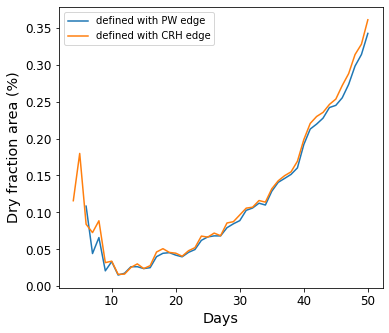

In [68]:
print("plot to compare edges defined from CRH and PW: dry fraction area")

x = data2D.time
fig,ax0 = plt.subplots(ncols=1,figsize=(6,5))

ax0.plot(x,edge_PW.fracarea_PW,label='defined with PW edge')
ax0.plot(x,edge_CRH.fracarea_CRH,label='defined with CRH edge')

# labels
ax0.set_xlabel('Days')
ax0.set_ylabel('Dry fraction area (%)')
ax0.legend()

# save and close figure
plt.savefig(os.path.join(figdir,simname,"dry_fracarea_fromPWandCRHedge.pdf"),bbox_inches='tight')
plt.show()

In [69]:
print("compute horizontal speed on edge")

UHSFC = np.sqrt(data2D.USFC**2 + data2D.VSFC**2)

edge_CRH.computeStatOnEdge(UHSFC,varid='UHSFC')
edge_PW.computeStatOnEdge(UHSFC,varid='UHSFC')

compute horizontal speed on edge


### Save edges

In [70]:
print("save edges defined from PW and CRH")

pickle.dump(edge_PW,open(os.path.join(resultdir,simname,"edge_PW.p"),"wb"))
pickle.dump(edge_CRH,open(os.path.join(resultdir,simname,"edge_CRH.p"),"wb"))

save edges defined from PW and CRH


## Absolute stats over time

In [81]:
print("compute PW and CRH stats")

r_refs = [10,25,50,75,90]

# PW
dist_PW = DistributionOverTime(name='PW',time_ref=data2D.time)
dist_PW.computeDistributions(data2D.PW)
dist_PW.computeIndividualPercentiles(data2D.PW,r_refs)
# CRH
dist_CRH = DistributionOverTime(name='CRH',time_ref=data2D.time)
dist_CRH.computeDistributions(data2D.CRH)
dist_CRH.computeIndividualPercentiles(data2D.CRH,r_refs)

compute PW and CRH stats


plot to compare aggregation definitions: PW/CRH at boundary and percentiles


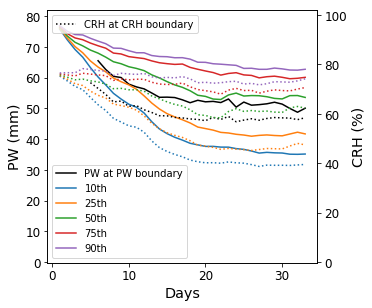

In [82]:
print("plot to compare aggregation definitions: PW/CRH at boundary and percentiles")

x = data2D.time
fig,ax0 = plt.subplots(ncols=1,figsize=(5,4.5))

# ax0.plot(x,edge_PW.fracarea_PW,label='defined with PW edge')
# ax0.plot(x,edge_CRH.fracarea_CRH,label='defined with CRH edge')

varids = 'PW','CRH'
lt = '-',':'
# col_r = 
ax1 = ax0.twinx()
axs = [ax0,ax1]

for i in range(2):

    v = varids[i]
    edge = getattr(thismodule,"edge_%s"%v)
    dist = getattr(thismodule,"dist_%s"%v)
    
    # plot mean value at boundary
    axs[i].plot(x,getattr(edge,"%s_mean"%v),c='k',label='%s at %s boundary'%(v,v),linestyle=lt[i])
    # plot percentiles
    for i_r in range(len(r_refs)):
        r = r_refs[i_r]
        lab = None
        if i == 0: # turn off labels for CRH percentiles
            lab = '%2.0fth'%r
        axs[i].plot(dist.time,getattr(dist,"perc%2.0f"%r),label=lab,linestyle=lt[i])

# labels
ax0.set_xlabel('Days')
ax0.set_ylabel('PW (mm)')
ax1.set_ylabel('CRH (%)')
ax1.set_ylim((-0.2,102))
ax0.set_ylim((-0.2,82))
# ax0.set_ylim((44.8,112))
ax0.legend()
ax1.legend(loc='upper left')

# save and close figure
plt.savefig(os.path.join(figdir,simname,"PW_and_CRH_at_edge_vs_percentile.pdf"),bbox_inches='tight')
plt.show()

plot to compare aggregation definitions: dry fraction area from border and PW/CRH percentiles


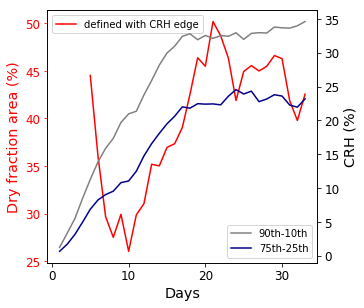

In [83]:
print("plot to compare aggregation definitions: dry fraction area from border and PW/CRH percentiles")

x = data2D.time
fig,ax0 = plt.subplots(ncols=1,figsize=(5,4.5))

# ax0.plot(x,edge_PW.fracarea_PW,label='defined with PW edge')
# ax0.plot(x,edge_CRH.fracarea_CRH,label='defined with CRH edge')

# varids = 'PW','CRH'
# varids = 'PW',
varids = 'CRH',
lt = '-',':'

for i in range(len(varids)):

    v = varids[i]
    edge = getattr(thismodule,"edge_%s"%v)
    dist = getattr(thismodule,"dist_%s"%v)
    
    ax0.plot(x,getattr(edge,"fracarea_%s"%v)*100,c='r',label='defined with %s edge'%v,linestyle=lt[i])
    ax1 = ax0.twinx()
    ax1.plot(dist.time,dist.perc90-dist.perc10,c='Gray',label='90th-10th',linestyle=lt[i])
    ax1.plot(dist.time,dist.perc75-dist.perc25,c='DarkBlue',label='75th-25th',linestyle=lt[i])
    
    ax1.spines['right'].set_position(('data',ax1.get_xlim()[1]+i*10))
    ax1.set_ylabel('%s (%s)'%(v,data2D[v].units))

# labels
ax0.set_xlabel('Days')
ax0.set_ylabel('Dry fraction area (%)')
ax0.tick_params(axis='y', colors='red')
ax0.yaxis.label.set_color('red')
ax0.legend()

ax1.legend(loc='lower right')

# save and close figure
plt.savefig(os.path.join(figdir,simname,"dry_fracarea_edge_vs_percentile_from_%s_edge.pdf"%('_'.join(varids))),bbox_inches='tight')
plt.show()

### Save distributions

In [84]:
print("save PW and CRH ditributions")

pickle.dump(dist_PW,open(os.path.join(resultdir,simname,"dist_PW.p"),"wb"))
pickle.dump(dist_CRH,open(os.path.join(resultdir,simname,"dist_CRH.p"),"wb"))

save PW and CRH ditributions


## Conditional stats

In [85]:
def gaussian_filter_xy(arr,sigma=8):
    """Smooth in x an y and recombine with same shape.
    Assumes dimensions T,Z,Y,X"""
    
    ashape = arr.shape
    
    if len(ashape) == 3:
        Nt,Ny,Nx = ashape
        Nz = 0
    elif len(ashape) == 4:
        Nt,Nz,Ny,Nx = ashape
    
    arr_out = np.nan*np.zeros(ashape)
    
    for i_t in range(Nt):
        
        if Nz == 0:
            arr_out[i_t,:,:] = gaussian_filter(arr[i_t,:,:],sigma=sigma,mode='wrap')
        
        else:
            for i_z in range(Nz):

                arr_out[i_t,i_z,:,:] = gaussian_filter(arr[i_t,i_z,:,:],sigma=sigma,mode='wrap')
            
    return arr_out

In [86]:
print("smooth data before computing conditional statistics")

PW_smooth = gaussian_filter_xy(data2D.PW,8)
CRH_smooth = gaussian_filter_xy(data2D.CRH,8)
W_smooth = gaussian_filter_xy(data3D.W,8)
QRAD_smooth = gaussian_filter_xy(data3D.QRAD,8)
QV_smooth = gaussian_filter_xy(data3D.QV,8)

smooth data before computing conditional statistics


In [87]:
print("compute reference statistics")

width = 10

# PW
dist_PW_smooth = DistributionOverTime(name='PW_smooth',width=width,time_ref=data2D.time)
dist_PW_smooth.computeDistributions(PW_smooth)
dist_PW_smooth.storeSamplePoints(PW_smooth)
dist_PW_smooth.computeIndividualPercentiles(PW_smooth,r_refs)
# CRH
dist_CRH_smooth = DistributionOverTime(name='CRH_smooth',width=width,time_ref=data3D.time)
dist_CRH_smooth.computeDistributions(CRH_smooth)
dist_CRH_smooth.storeSamplePoints(CRH_smooth)
dist_CRH_smooth.computeIndividualPercentiles(CRH_smooth,r_refs)

compute reference statistics
0_11 ; 1_12 ; 2_13 ; 3_14 ; 4_15 ; 5_16 ; 6_17 ; 7_18 ; 8_19 ; 9_20 ; 10_21 ; 11_22 ; 12_23 ; 13_24 ; 14_25 ; 15_26 ; 16_27 ; 17_28 ; 18_29 ; 19_30 ; 20_31 ; 21_32 ; 22_33 ; 
0_11 ; 1_12 ; 2_13 ; 3_14 ; 4_15 ; 5_16 ; 6_17 ; 7_18 ; 8_19 ; 9_20 ; 10_21 ; 11_22 ; 12_23 ; 13_24 ; 14_25 ; 15_26 ; 16_27 ; 17_28 ; 18_29 ; 19_30 ; 20_31 ; 21_32 ; 22_33 ; 


In [88]:
print("save reference distributions")

pickle.dump(dist_PW_smooth,open(os.path.join(resultdir,simname,"dist_PW_smooth_dt%s.p"%width),"wb"))
pickle.dump(dist_CRH_smooth,open(os.path.join(resultdir,simname,"dist_CRH_smooth_dt%s.p"%width),"wb"))


save reference distributions


In [89]:
print("compute conditional profiles")

refvars = 'PW','CRH'
# condvars = 'W',"QRAD"
condvars = "QV",

for refvar in refvars:
    for condvar in condvars:

        # initialize
        refdata = getattr(thismodule,"dist_%s_smooth"%refvar)
        d = ConditionalDistributionOverTime(name=condvar,
                                            time_ref=data2D.time,
                                            width = width,
                                            is3D=True,
                                            isTime=True,
                                            on=refdata)
        
        # compute
        conddata = getattr(thismodule,"%s_smooth"%condvar)
        d.computeConditionalStatsOverTime(conddata)
        
        setattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar),d)

compute conditional profiles


In [90]:
print("save conditional distributions")

refvars = 'PW','CRH'
# condvars = 'W',"QRAD"
condvars = "QV",

for refvar in refvars:
    for condvar in condvars:
        
        cdist = getattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar))
        savename = "cdist_%s_on_%s_smooth_dt%s.p"%(condvar,refvar,width)

        pickle.dump(cdist,open(os.path.join(resultdir,simname,savename),"wb"))

save conditional distributions


## Tests